<a href="https://colab.research.google.com/github/robert-shepherd/fpl/blob/main/Project_3_4_ridge_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ridge regression model


---

The purpose of this script is to develop the ridge regression model

Data sources:
* Data post feature engineering:  https://raw.githubusercontent.com/robert-shepherd/fpl/main/fpl_features.csv


In [ ]:
# Loading libraries
import pandas as pd
import pickle
import numpy as np
import scipy.stats as stats
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Model libraries
from sklearn.linear_model import Ridge

# Import measures
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

## Setup

In [ ]:
# Reading in files from static output
X_train_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/X_train.csv'
X_test_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/X_test.csv'
Y_train_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/Y_train.csv'
Y_test_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/Y_test.csv'

X_train = pd.read_csv(X_train_url)
X_test = pd.read_csv(X_test_url)
Y_train = pd.read_csv(Y_train_url,squeeze=True)
Y_test = pd.read_csv(Y_test_url,squeeze=True)

print('X_train      : ',X_train.shape)
print('X_test       : ',X_test.shape)
print('Y_train      : ',Y_train.shape)
print('Y_test       : ',Y_test.shape)

X_train      :  (40388, 40)
X_test       :  (10098, 40)
Y_train      :  (40388,)
Y_test       :  (10098,)


In [ ]:
# Creating a copy with missing values removed
train_na = X_train.isnull().any(axis=1)
test_na = X_test.isnull().any(axis=1)

X_train_no_na = X_train[~train_na]
Y_train_no_na = Y_train[~train_na]

X_test_no_na = X_test[~test_na]
Y_test_no_na = Y_test[~test_na]

print('X_train_no_na      : ',X_train_no_na.shape)
print('X_test_no_na       : ',X_test_no_na.shape)
print('Y_train_no_na      : ',Y_train_no_na.shape)
print('Y_test_no_na       : ',Y_test_no_na.shape)

X_train_no_na      :  (32698, 40)
X_test_no_na       :  (8195, 40)
Y_train_no_na      :  (32698,)
Y_test_no_na       :  (8195,)


## Default regression model


In [ ]:
# Training default Ridge model
ridge = Ridge(normalize=True)
ridge.fit(X_train_no_na,Y_train_no_na)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
# Predicting on test
y_pred = ridge.predict(X_test_no_na)

In [ ]:
# Checking min/max prediction
min_pred = min(y_pred)
max_pred = max(y_pred)
print("Min prediction: {}".format(min_pred))
print("Max prediction: {}".format(max_pred))

Min prediction: 0.020441245389502205
Max prediction: 7.3423646510534155


In [ ]:
r2 = ridge.score(X_test_no_na, Y_test_no_na)
print("R squared: {}".format(r2))

R squared: 0.24340311504592937


## Evaluating bias/variance tradeoff


In [ ]:
# Checking 10 fold cross validation error
MSE_CV_scores = cross_val_score(ridge, X_train_no_na, Y_train_no_na, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

cv_mse = abs(MSE_CV_scores.mean())

print("CV MSE: {}".format(cv_mse))

CV MSE: 4.7847154097772355


In [ ]:
# Checking test MSE
test_mse = mean_squared_error(Y_test_no_na, y_pred)
print("Test MSE: {}".format(test_mse))

Test MSE: 4.81669381152178


In [ ]:
# Checking training MSE
y_pred_train = ridge.predict(X_train_no_na)
train_mse = mean_squared_error(Y_train_no_na, y_pred_train)
print("Train MSE: {}".format(train_mse))

Train MSE: 4.776450589497557


## Optimising alpha selection

In [ ]:
# Setup
ridge = Ridge(normalize=True)

alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

In [ ]:
# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge,X_train_no_na,Y_train_no_na,cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

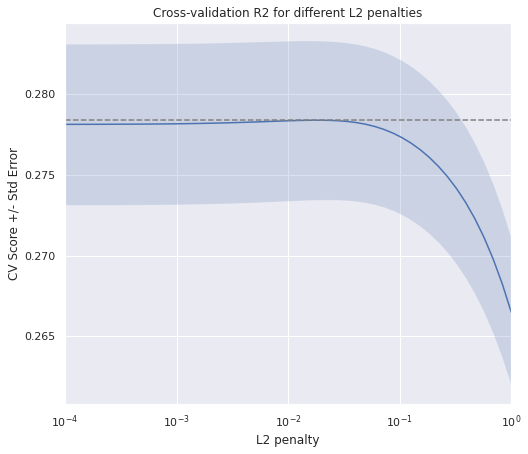

In [ ]:
# Display plot
sns.set()
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(1,1,1)
plt.plot(alpha_space, ridge_scores)

std_error = ridge_scores_std / np.sqrt(10)

ax.fill_between(alpha_space, ridge_scores + std_error, ridge_scores - std_error, alpha=0.2)
ax.set_ylabel('CV Score +/- Std Error')
ax.set_xlabel('L2 penalty')
ax.axhline(np.max(ridge_scores), linestyle='--', color='.5')
ax.set_xlim([alpha_space[0], alpha_space[-1]])
ax.set_xscale('log')
plt.title("Cross-validation R2 for different L2 penalties")
plt.show()

In [ ]:
~# Using grid search to identify the optimum alpha level
ridge = Ridge(normalize=True)
param_grid = {'alpha': alpha_space}

gm_cv = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=10)

gm_cv.fit(X_train_no_na,Y_train_no_na)

y_pred = gm_cv.predict(X_test_no_na)
r2 = gm_cv.score(X_test_no_na, Y_test_no_na)
mse = mean_squared_error(Y_test_no_na, y_pred)

print("Ridge best CV score: {}".format(gm_cv.best_score_))
print("Tuned Ridge l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned Ridge R squared: {}".format(r2))
print("Tuned Ridge MSE: {}".format(mse))


Ridge best CV score: 0.2784039503258891
Tuned Ridge l1 ratio: {'alpha': 0.019306977288832496}
Tuned Ridge R squared: 0.2538090818604939
Tuned Ridge MSE: 4.750446702981733


## Understanding feature importance

In [ ]:
# Training Lasso model
ridge = Ridge(normalize=True,alpha=0.019306977288832496)
ridge.fit(X_train_no_na,Y_train_no_na)

Ridge(alpha=0.019306977288832496, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=True, random_state=None, solver='auto',
      tol=0.001)

In [ ]:
# Checking which variables have the largest coefficients
ridge_coef = ridge.coef_
df_columns = X_test_no_na.columns

coef_df = pd.DataFrame(df_columns,columns=['feature'])
coef_df['coefficients'] = ridge_coef
coef_df['coefficients_abs'] = abs(ridge_coef)

coef_df.sort_values(by=['coefficients_abs'],ascending=False).head(20)

,feature,coefficients,coefficients_abs
35,transfers_out_ratio_rolling,0.916282,0.916282
33,transfers_in_ratio_rolling,-0.762230,0.762230
21,bonus_rolling,-0.458717,0.458717
11,assists_rolling,0.343536,0.343536
17,saves_rolling,0.246540,0.246540
8,goals_scored_lag,-0.240807,0.240807
36,was_home_True,0.220829,0.220829
34,transfers_out_ratio_lag,-0.219581,0.219581
0,opponent_strength,-0.209610,0.209610
10,assists_lag,-0.187210,0.187210


In [ ]:
# Setting default Seaborn style
sns.set(rc={'figure.figsize':(10,8)})

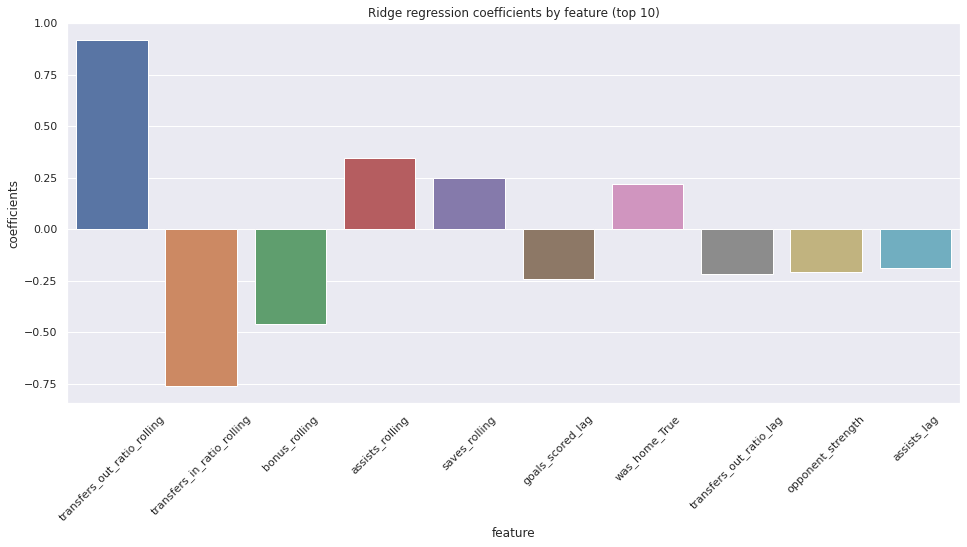

In [ ]:
# Plot coefficients
top_10_features = coef_df.sort_values(by=['coefficients_abs'],ascending=False).head(10)
plt.figure(figsize=(16,7))
plt.xticks(rotation=45) 
sns.barplot(x='feature', y='coefficients',data=top_10_features)
plt.title('Ridge regression coefficients by feature (top 10)')
plt.show()